# VAE for MNIST  

The purpose of this demo is to help you learn about variational autoencoder. The algorithm is being implemented is from the paper "Auto-Encoding Variational Bayes", by Diederik P Kingma, Max Welling (https://arxiv.org/abs/1312.6114).

Followed the logic in https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py.

You are free to change model acrhitecture, or any part of the logic. 

If you have any suggestions or find errors, please, don't be hesitate to text me at jayanta.jayantamukherjee@gmail.com


In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r

### VAE Models 

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

### VAE

In [7]:
class VAE(torch.nn.Module):
    latent_dim = 8

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, 8)
        self._enc_log_sigma = torch.nn.Linear(100, 8)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)

#### Modeling Loss
KL

In [8]:
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

#### Running VAE Model

In [ ]:
input_dim = 28 * 28
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor()])
mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

print('Number of samples: ', len(mnist))

encoder = Encoder(input_dim, 100, 100)
decoder = Decoder(8, 100, input_dim)
vae = VAE(encoder, decoder)

criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.0001)
l = None
for epoch in range(100):
    for i, data in enumerate(dataloader, 0):
        inputs, classes = data
        inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes)
        optimizer.zero_grad()
        dec = vae(inputs)
        ll = latent_loss(vae.z_mean, vae.z_sigma)
        loss = criterion(dec, inputs) + ll
        loss.backward()
        optimizer.step()
        l = loss.data.item()
    print(epoch, l)

plt.imshow(vae(inputs).data[0].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

Number of samples:  60000
0 0.0696125403046608
1 0.06582479178905487
2 0.06148030236363411
3 0.06445472687482834
4 0.07611803710460663
5 0.06885048002004623
6 0.0688997358083725
7 0.07185737788677216
8 0.06961432844400406
9 0.07246511429548264
10 0.06627078354358673
11 0.0659715086221695
12 0.06962501257658005
13 0.06482045352458954
14 0.06113708019256592
15 0.07270865142345428
16 0.06729210913181305
17 0.07067185640335083
18 0.07205890119075775
19 0.06982989609241486
20 0.06891864538192749
21 0.06812287122011185
22 0.06501396000385284
23 0.06342468410730362
24 0.0655825212597847
25 0.07090935856103897
26 0.06448943167924881
27 0.06818002462387085
28 0.06436075270175934
29 0.0681985467672348
30 0.06821585446596146
31 0.06671841442584991
32 0.0708414688706398
33 0.07363526523113251
34 0.06840085983276367
35 0.06972502917051315
36 0.0644509419798851
37 0.06891821324825287


In [ ]:
plt.imshow(vae(inputs).data[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

In [ ]:
plt.imshow(vae(inputs).data[2].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

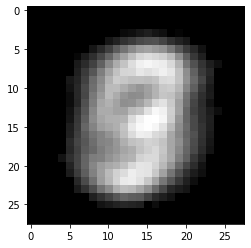

In [6]:
plt.imshow(vae(inputs).data[3].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

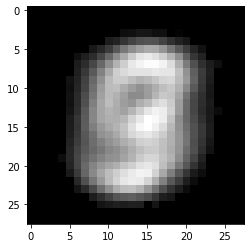

In [9]:
plt.imshow(vae(inputs).data[4].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

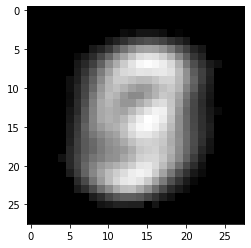

In [10]:
plt.imshow(vae(inputs).data[5].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

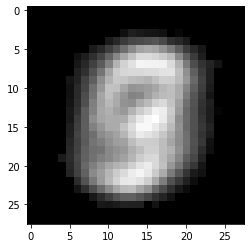

In [11]:
plt.imshow(vae(inputs).data[6].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

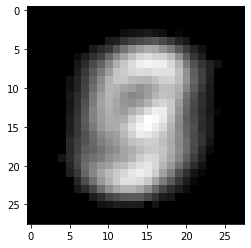

In [12]:
plt.imshow(vae(inputs).data[7].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

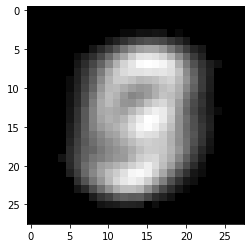

In [13]:
plt.imshow(vae(inputs).data[8].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

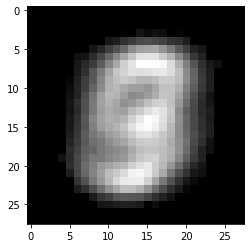

In [14]:
plt.imshow(vae(inputs).data[9].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

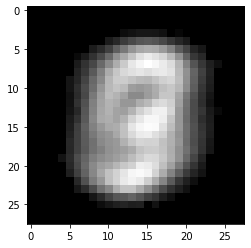

In [15]:
plt.imshow(vae(inputs).data[10].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

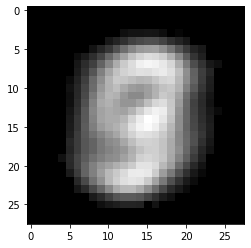

In [16]:
plt.imshow(vae(inputs).data[11].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

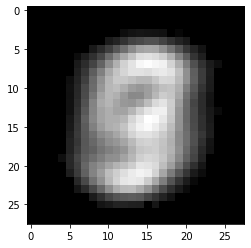

In [17]:
plt.imshow(vae(inputs).data[12].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

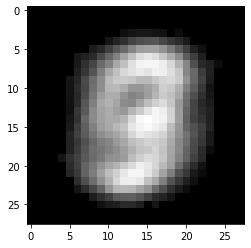

In [18]:
plt.imshow(vae(inputs).data[13].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

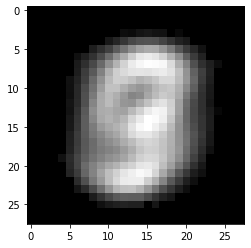

In [19]:
plt.imshow(vae(inputs).data[14].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

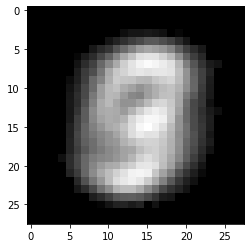

In [20]:
plt.imshow(vae(inputs).data[15].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

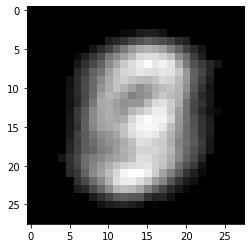

In [21]:
plt.imshow(vae(inputs).data[16].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

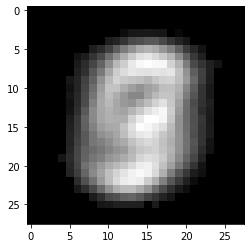

In [22]:
plt.imshow(vae(inputs).data[17].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

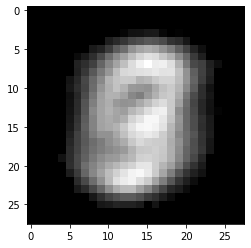

In [23]:
plt.imshow(vae(inputs).data[18].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

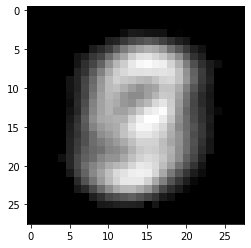

In [24]:
plt.imshow(vae(inputs).data[19].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

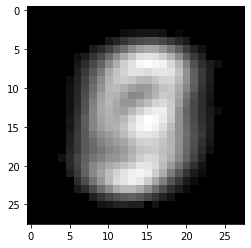

In [25]:
plt.imshow(vae(inputs).data[20].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

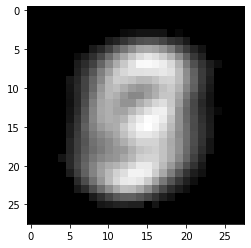

In [26]:
plt.imshow(vae(inputs).data[21].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

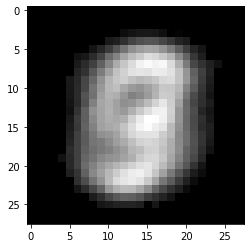

In [27]:
plt.imshow(vae(inputs).data[22].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

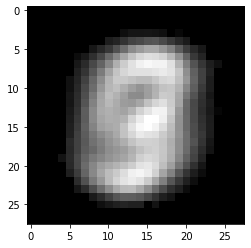

In [28]:
plt.imshow(vae(inputs).data[23].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

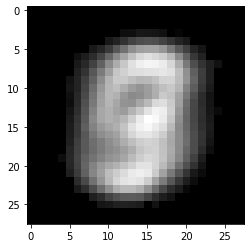

In [29]:
plt.imshow(vae(inputs).data[24].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

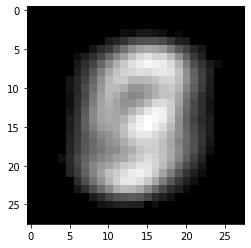

In [30]:
plt.imshow(vae(inputs).data[25].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

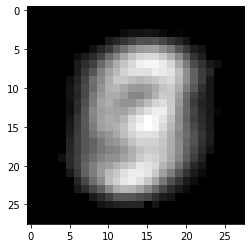

In [31]:
plt.imshow(vae(inputs).data[26].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

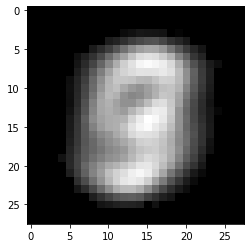

In [32]:
plt.imshow(vae(inputs).data[27].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

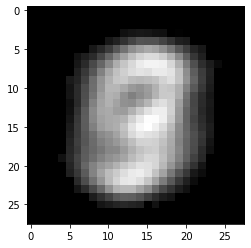

In [33]:
plt.imshow(vae(inputs).data[28].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

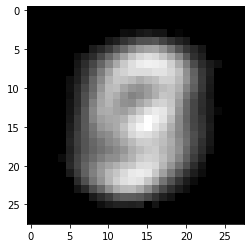

In [34]:
plt.imshow(vae(inputs).data[29].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

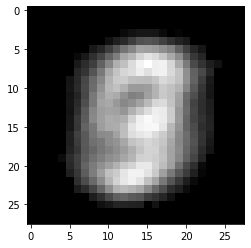

In [35]:
plt.imshow(vae(inputs).data[30].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

In [36]:
print(vae(inputs).data.shape) 

torch.Size([32, 784])


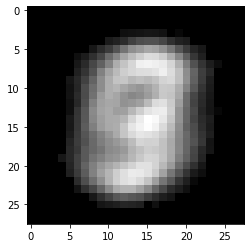

In [8]:
plt.imshow(vae(inputs).data[31].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)